# Project 2 - COSC 528
## October 22, 2018
## Author: Ian R. Stewart

In [1]:
import pandas as pd
import numpy as np
import itertools
import tabulate
import warnings
warnings.filterwarnings("ignore")

# importing SVD library to extract PCs
from scipy.linalg import svd

# plotting libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Importing Data

In [2]:
df = pd.read_excel('UTK-peers.xlsx')

Dropping empty rows from imported file

In [3]:
first_row_with_all_NaN = df.shape[0]-df[df.isnull().all(axis=1) == True].shape[0]
df = df.loc[0:first_row_with_all_NaN-1]
df = df.set_index(df['Name'])
df.head()

,Name,IPEDS#,Carm R1,HBC,% Blk Total Students,% Hisp Total Students,2017 US News top 65,2014 Med School,Vet School,Total Enroll,...,ACT/ SAT 25%,ACT/ SAT 75%,(State/ Tuit)/ St. FTE,Med School Res $,Academic Support Expenditures,Student Services Expenditures,Endowment Figure,Endowment per Student FTE,Total Faculty.1,Total Tenure /Tenure-Track Facutly.1
Name,,,,,,,,,,,,,,,,,,,,,
Univ. of Tennessee - Knoxville,Univ. of Tennessee - Knoxville,221759.0,1.0,No,6.625965,3.404561,46.0,NaN,x,27845.0,...,24.0,30.0,22093.596931,0.0,7.827344e+08,30587.112868,7.827344e+08,30587.112868,1526.0,1117.0
Univ. of Georgia,Univ. of Georgia,139959.0,1.0,No,8.048713,4.732909,18.0,NaN,x,36130.0,...,25.0,30.0,23743.789087,0.0,9.390242e+08,27830.636107,9.390242e+08,27830.636107,1918.0,1606.0
Purdue Univ.,Purdue Univ.,243780.0,1.0,No,2.994663,4.128780,20.0,NaN,x,40472.0,...,23.0,30.0,25230.954999,0.0,2.445542e+09,66375.581533,2.445542e+09,66375.581533,1783.0,1700.0
Texas A&M Univ.,Texas A&M Univ.,228723.0,1.0,No,3.203109,19.193581,27.0,pre clin,x,63813.0,...,23.0,29.0,29423.418111,52058.0,1.052103e+10,180613.450122,1.052103e+10,180613.450122,2983.0,1995.0
Michigan State Univ.,Michigan State Univ.,171100.0,1.0,No,6.591080,4.020737,33.0,x,x,50538.0,...,23.0,28.0,22975.311112,52594.0,2.549137e+09,55180.107179,2.549137e+09,55180.107179,2616.0,1811.0


Dropping unique features from dataframe and large amounts of missing values.

In [4]:
df = df.drop(['IPEDS#','HBC','Carm R1','Med School Res $','AG Research ($000)','Med School Res $','Academic Support Expenditures','Profess Degrees'],axis=1)

Dropping indexs where multiple missing values within remaining data features.

In [5]:
df = df.drop(['Univ. of Pittsburgh ','Delaware','Univ. of Colorado '],axis=0)
df.shape

(54, 58)

Searching for features with missing or null values.

In [6]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print df.columns.values[indexes]

[u'2014 Med School' u'Vet School' u'Endowment' u'Wall St. Jourl Rank'
 u'Enowment / St. FTE']


Inserting correct WSJ College Rankings from following reference: https://www.timeshighereducation.com/sites/default/files/breaking_news_files/wsj-the-college-rankings-2017-results.pdf

University with partial names, such 'Utah', were confirmed to be specific universities via the IPEDS number.

In [7]:
df['Wall St. Jourl Rank'][df['Name']=='Delaware']=137
df['Wall St. Jourl Rank'][df['Name']=='Colorado State']=353
df['Wall St. Jourl Rank'][df['Name']==' Arizona State']=131
df['Wall St. Jourl Rank'][df['Name']=='Georgia Tech']=51
df['Wall St. Jourl Rank'][df['Name']=='UC-Irvine']=153
df['Wall St. Jourl Rank'][df['Name']=='UC-San Diego']=49
df['Wall St. Jourl Rank'][df['Name']=='Connecticut']=110
df['Wall St. Jourl Rank'][df['Name']==' Iowa']=164
df['Wall St. Jourl Rank'][df['Name']=='Buffalo']=130
df['Wall St. Jourl Rank'][df['Name']=='Utah']=311
df['Wall St. Jourl Rank'][df['Name']=='UC-Riverside']=368
df['Wall St. Jourl Rank'][df['Name']==' Arizona']=162

In [8]:
df['2014 Med School'][df['2014 Med School']=='x']=1
df['2014 Med School'][df['2014 Med School']=='pre clin']=1
df['2014 Med School'][df['2014 Med School']!=int(1)]=0
df['Vet School'][df['Vet School']!='x']=0
df['Vet School'][df['Vet School']=='x']=1
df['Endowment'][df['Name']=='Clemson Univ.']=621.3E6

In [9]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: [u'Enowment / St. FTE']


Error in feature label. Fixing typo of label "Enowment / St. FTE" to "Endowment / St. FTE"

In [10]:
df.rename(columns={"Enowment / St. FTE":"Endowment / St. FTE"},inplace=True)

Fixing NaN value in Endowment / St. FTE ; It should be noted that after checking the other values for this feature, the Endowment divided by St. FTE is *NOT* exactly the reported value in the provided data.

In [11]:
count = 0
for i in df["Endowment / St. FTE"]:
    j = str(i)
    if j == "nan":
        name = df['Name'][count]
        endowment = df['Endowment'][df['Name']==name]
        fte = df['ST. FTE'][df['Name']==name]
        df["Endowment / St. FTE"][df['Name']==name]=int(endowment / fte)
    count+=1

Re-verifying that all features have are filled with no missing data.

In [12]:
count = 0; indexes = []
for i in df.isnull().any():
    if i == True:
        indexes.append(count)
    count+=1
print 'Feautures with missing data: %s'%df.columns.values[indexes]

Feautures with missing data: []


Fixing data types on manipulated data feautures.

In [13]:
df['Name']=df['Name'].astype('|S')
df['Vet School']=df['Vet School'].astype(float)
df['2014 Med School']=df['2014 Med School'].astype(float)

Now that the data has been explored with appropriate handling of the unique features and missing data, let's create a data matrix containing soley the numeric attributes for analysis.

In [14]:
analysis = df.iloc[:,1::] # Essentially, we are only dropping the university name

In [15]:
analysis.shape

(54, 57)

Performed z-Standardization while mean-centering the data prior to analysis.

In [16]:
# Centering each data feature
a_standardized=(analysis.iloc[:,0::]-analysis.iloc[:,0::].mean())/analysis.iloc[:,0::].std()

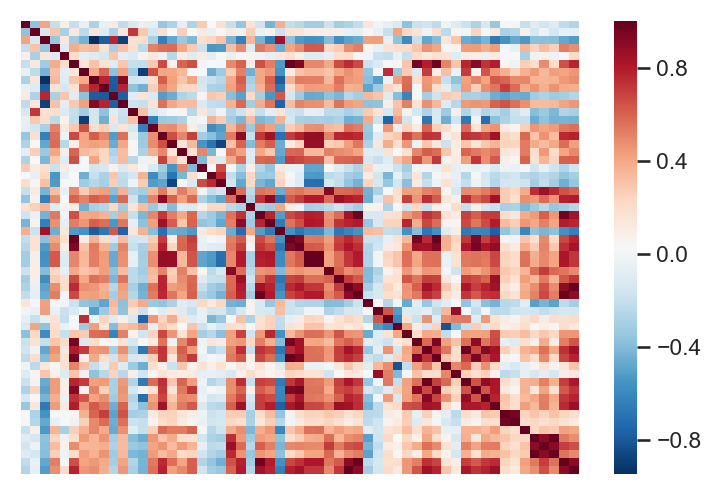

In [17]:
# Exploring correlation matrix
cols = list(a_standardized.columns.values)
corr = np.corrcoef(a_standardized.values.T)
plt.figure(dpi=150)
sns.set(font_scale=1.0)
sns.heatmap(corr,cbar=True,cmap="RdBu_r",yticklabels=[],xticklabels=[])

### **Analysis**

Finding factorized matrices from created analysis matrix. For the matrix **Analysis** with (*57x54*), the expected sizes of the factorized matrices are as follows: **U**(*54x54*), **Sigma**(*54x54*), and **VT**(*57x57*). Of note, the package utilized here (SciPy.linalg.SVD) outputs a single column (57-length vector) for **Sigma**, which is actually a diagonal matrix and not a single column vector matrix. These values are known as the singular values of the original matrix **Analysis**, while **U** and **VT** are referred to as the left-singular and right-singular vectors of **Analysis**, respectively.

In [18]:
U, Sigma, VT = svd(a_standardized)

In [19]:
# Verifying shape of SVD from SciPy.linalg.SVD function
U.shape,Sigma.shape,VT.shape

((54, 54), (54,), (57, 57))

Now that the matrix decomposition is complete, we must find the optimal threshold for the number of dimensions to retain. To assist in making this decision, we can create a Scree plot to visualize the data. Of note, the variance is calculated by squaring the singular values (i.e. values in **Sigma** vector).

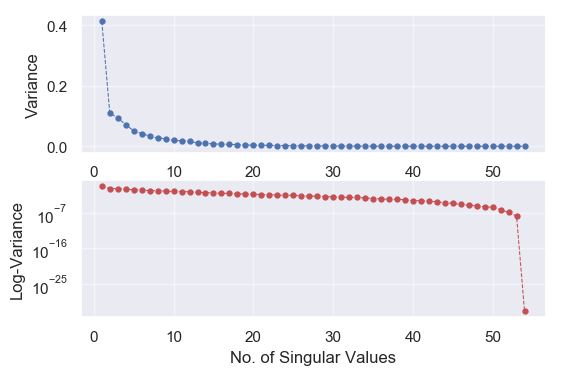

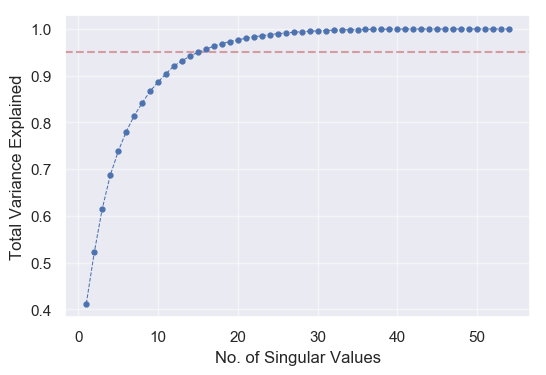

In [20]:
# Calc. Variance for each PC
variance_sigma = Sigma**2/np.cumsum(Sigma**2)[-1]

# Calc. Total Variance Explained for each PC step
PC_no = np.arange(1,len(variance_sigma)+1)
total_variance = []
for i in range(len(variance_sigma)):
    var = variance_sigma[i]
    if i == 0:
        total_variance.append(var)
    else:
        total_variance.append(total_variance[i-1]+var)

fig, (ax,ax1) = plt.subplots(nrows=2,dpi=100)
ax.plot(PC_no,variance_sigma,'o--',markersize=3.5,linewidth=0.75)
ax.grid(alpha=0.5)
ax.set_ylabel('Variance')
ax1.plot(PC_no,variance_sigma,'ro--',markersize=3.5,linewidth=0.75)
ax1.set_ylabel('Log-Variance')
ax1.set_xlabel('No. of Singular Values')
ax1.set_yscale('log')
ax1.grid(which='both',alpha=0.5)
#plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/Variance_Explained_Per_PC.png',format='png',dpi=600)

fig, ax = plt.subplots(dpi=100)
ax.plot(PC_no,total_variance,'o--',markersize=3.5,linewidth=0.75,zorder=2)
ax.grid(alpha=0.5)
ax.set_ylabel('Total Variance Explained')
ax.set_xlabel('No. of Singular Values')
plt.axhline(0.95,color='r',linestyle='--',alpha=0.5,zorder=1)
#plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/Total_Variance_Explained.png',format='png',dpi=600)

In [21]:
# Print Variance and Total Variance explained by each Principal Component (PC)
n = 20
print tabulate.tabulate({"P.C.": PC_no[0:n],"Variance Explained":total_variance[0:n],"P.C. Variance": variance_sigma[0:n]}, headers="keys")

  P.C.    P.C. Variance    Variance Explained
------  ---------------  --------------------
     1       0.412627                0.412627
     2       0.109848                0.522474
     3       0.0932738               0.615748
     4       0.0713672               0.687116
     5       0.0512241               0.73834
     6       0.0420141               0.780354
     7       0.0340335               0.814387
     8       0.0272946               0.841682
     9       0.0253092               0.866991
    10       0.0195205               0.886511
    11       0.0182155               0.904727
    12       0.0162219               0.920949
    13       0.0108676               0.931816
    14       0.0102284               0.942045
    15       0.00792793              0.949973
    16       0.00683807              0.956811
    17       0.00654667              0.963358
    18       0.005461                0.968819
    19       0.00419952              0.973018
    20       0.00374557            

Comparing results for Explained Variance for Singular Values and Scikit-Learn PCA function (only for ***comparison*** purposes!)

In [34]:
from sklearn.decomposition import PCA
n = 20
pca = PCA(n_components=n)
pca.fit(a_standardized)
print 'No.\tSVD Variance\tSVD Total\tPCA Total'
for i in range(0,n):
    if i == 0:
        print "%i\t%.2f %%\t\t%.2f %%\t\t%.2f %%"%(i+1,np.sum(variance_sigma[i])*100,variance_sigma[i]*100,np.sum(pca.explained_variance_ratio_[i]*100))
    else:
        print  "%i\t%.2f %%\t\t%.2f %%\t\t%.2f %%"%(i+1,variance_sigma[i]*100,np.sum(variance_sigma[0:i+1])*100,np.sum(pca.explained_variance_ratio_[0:i+1]*100))

No.	SVD Variance	SVD Total	PCA Total
1	41.26 %		41.26 %		41.26 %
2	10.98 %		52.25 %		52.25 %
3	9.33 %		61.57 %		61.57 %
4	7.14 %		68.71 %		68.71 %
5	5.12 %		73.83 %		73.83 %
6	4.20 %		78.04 %		78.04 %
7	3.40 %		81.44 %		81.44 %
8	2.73 %		84.17 %		84.17 %
9	2.53 %		86.70 %		86.70 %
10	1.95 %		88.65 %		88.65 %
11	1.82 %		90.47 %		90.47 %
12	1.62 %		92.09 %		92.09 %
13	1.09 %		93.18 %		93.18 %
14	1.02 %		94.20 %		94.20 %
15	0.79 %		95.00 %		95.00 %
16	0.68 %		95.68 %		95.68 %
17	0.65 %		96.34 %		96.34 %
18	0.55 %		96.88 %		96.88 %
19	0.42 %		97.30 %		97.30 %
20	0.37 %		97.68 %		97.68 %


From the results, the first 11 principal components capture ~90% of the total data variability.

 Now, writing a function to reduce the data matrix to the first *k* PCs determined by using the previous calculation to meet a specific percentage of the variance captured in the PCs.

In [35]:
def getValues(n,V_transpose):
    '''
    @param n:           {int}   desired number of components
    @param V_transpose: {array} array matrix from SVD function
    return: original V function specified number of components
    '''
    V = V_transpose.T
    return V[:,0:n]

Creating distance function for calculating inter- and intra-cluster distances 

In [36]:
def intercluster_distance(centroids):
    '''
    @param centroids: {dictionary} data cluster centroids from K_means class
    return {2}: tuple(cluster_i,cluster_j),distance(i_to_j)
    '''
    dist = []
    cl = []
    for i in list(itertools.combinations(range(len(centroids)), 2)):
        squared_distance = 0
        i0 = np.array(centroids[i[0]])
        i1 = np.array(centroids[i[1]])
        for j in range(len(i0)):
            squared_distance += (i0[j]-i1[j])**2
        cl.append(i)
        dist.append(np.sqrt(squared_distance))
    return cl,dist

def intracluster_distance(clusters):
    '''
    @param clusters: {dictionary} data cluster from K_means class
    return {1}: list(float(distance_between_points))
    '''
    cl = []
    dist = []
    for i in clusters:
        for j in list(itertools.combinations(range(len(clusters[i])), 2)): 
            squared_distance = 0
            j0 = np.array(clusters[i][j[0]])
            j1 = np.array(clusters[i][j[1]])
            for j in range(len(j0)):
                squared_distance += (j0[j]-j1[j])**2
            cl.append(i)
            dist.append(np.sqrt(squared_distance))
    return dist

### **Creating Class for** ***K-Means*** **Calculation on decomposed data**

In [37]:
class K_means:
    '''
    This do k_means on some foolish dataset that don't need no man bc it is iid and strong.
    e.g. 
        a = K_means(2) # Two clusters
        a.main(data)   # calc. clusters and centroids
        a.centroids    # cluster centroid values
        a.clusters     # values in clusters
    '''
    
    def __init__(self,k=3,tol=0.001,max_iter=1000):
        '''
        @param k:         {int}   number of clusters
        @param tol:       {float} convergence tolerance to stop iterations
        @param max_iter:  {float} maximum no. of iterations if not converged prior
        '''
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
    
    def main(self,data):
        '''
        Decsription: Performing main function for K_mean algorithm.
            1. Initial guess for cluster centroids
            2. Initial number of cluster from provided <self.k> parameter
            3. Iterate over data:
                3.1. Calculate distance between current datum and cluster centroids
                3.2. Choose cluster with minimum distance between datum and centroid
                3.3. Update cluster centroid based on new data
                3.4. Continue to next datum in data
            4. return data clusters and centroids
            5. rerun process next iteration until convergence
                5.1. convergence 
        '''
        # Initializing centroids
        self.centroids = {}
        self.centroids_converged = {}
        
        for i in range(self.k):
            self.centroids[i] = data[i]      # Initial centroid guess
        
        # Iterate Data
        for i in range(self.max_iter):
            self.clusters = {}

            for j in range(self.k):
                self.clusters[j] = []

            # Calculating distance and choosing nearest class centroid
            for features in data:
                distances = [np.linalg.norm(features - self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances)) # calc. minimum distance to centroids
                self.clusters[classification].append(features)   # choose closest centroid for feature
            
            old_values = dict(self.centroids) # Storing values for convergence testing

            for classification in self.clusters:
                self.centroids[classification] = np.average(self.clusters[classification], axis = 0)

            converged = True # boolean check value for convergence
            
            counter = 0
            for centroid in self.centroids:
                
                # Checking if difference between centroids meet defined tolerance value
                if np.sum((self.centroids[centroid]-old_values[centroid])/old_values[centroid]*100.0)>self.tol:
                    converged = False
                else:
                    self.centroids_converged = i
                counter+=1

            # If centroid calc. converged==True --> break loop
            if converged: 
                break
    

Initializing class object with number of clusters

In [38]:
V = getValues(2,VT) # Only using first two PCs

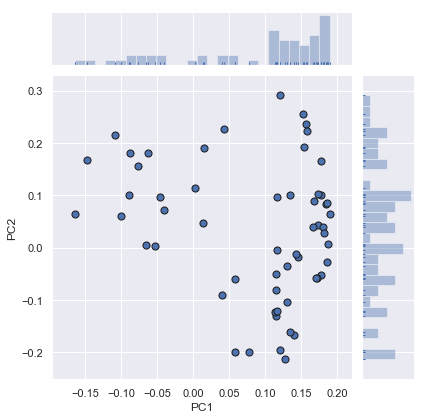

In [39]:
kmeans = K_means(1)
kmeans.main(V)
x=[];y=[]
for classification in kmeans.clusters:
    for features in kmeans.clusters[classification]:
        x.append(features[0]);y.append(features[1])
data = pd.DataFrame({
    'PC1': np.array(x),
    'PC2': np.array(y)})
h = sns.jointplot(x='PC1', y='PC2', data=data,\
                   marginal_kws=dict(bins=25, rug=True),\
                   s=50, edgecolor="k", linewidth=1)
#plt.savefig('C:\Users\IAN\Research\COSC 528\Project 2\Figures/PC2_jointplot.png',format='png',dpi=600)

##### Creating plots for Two PCs clustering using the created K_means class.

1-Clusters : Converged in 1 iterations
2-Clusters : Converged in 3 iterations
3-Clusters : Converged in 6 iterations


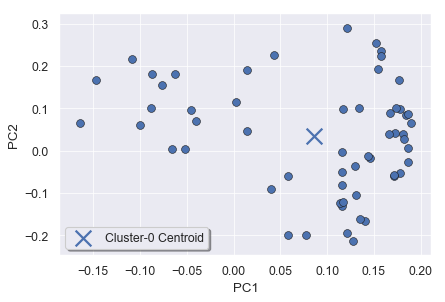

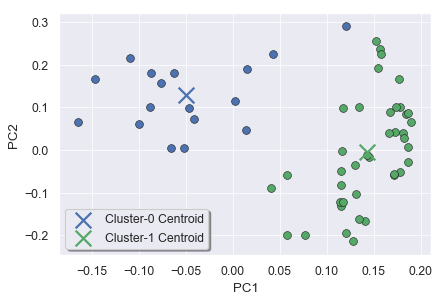

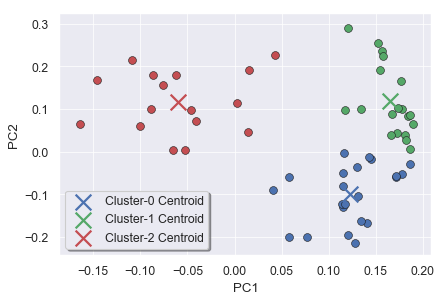

In [40]:
for i in range(1,4):
    kmeans = K_means(i)
    kmeans.main(V)
    
    c = ['b','g','r','c','m','y','k','w'] # python default plot colors for clusters
    fig,ax = plt.subplots(dpi=80)
    for classification in kmeans.clusters:
        color = c[classification]
        for features in kmeans.clusters[classification]:
            ax.scatter(features[0], features[1], color = color,s = 50,edgecolors='k',linewidth=0.5)

    for centroid in kmeans.centroids:
        legend_string = 'Cluster-%i Centroid'%centroid
        PC1 = kmeans.centroids[centroid][0]
        PC2 = kmeans.centroids[centroid][1]
        ax.scatter(PC1,PC2,s=200, marker="x",color=c[centroid],linewidth=2,label=legend_string)

    ax.grid(alpha=0.75)
    ax.set_axisbelow(True)
    ax.set_xlabel('PC1');ax.set_ylabel('PC2');
    ax.legend(loc='lower left',fancybox=True,shadow=True)
    #plt.savefig('/Users/i6o/Research/COSC 528/Project 2/Figures/'+'KMeans_Cluster_'+str(i)+'.png',format='png',dpi=200)
    print '%i-Clusters : Converged in %i iterations'%(i,kmeans.centroids_converged)
    

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8),dpi=80)
ax = fig.add_subplot(111, projection='3d')
for classification in kmeans.clusters:
    if len(kmeans.clusters[classification])>1:
        x=[];y=[];z=[]
        for features in kmeans.clusters[classification]:
            x.append(features[0])
            y.append(features[1])
            z.append(features[2])
        ax.scatter(x,y,z)
    else:
        x,y,z = features[0], features[1],features[3]
        ax.scatter(x,y,z)

Checking intercluster and intracluster cluster distances to acquire the Dunn Index. Comparing results with *sklearn.cluster.KMeans* function.

In [42]:
from sklearn.cluster import KMeans
V = getValues(2,VT) # Only using first two PCs
kmeans_sklearn = KMeans(n_clusters=3, random_state=0).fit(V)
kmeans = K_means(3); kmeans.main(V)
print kmeans_sklearn.cluster_centers_
print kmeans.centroids

[[-0.06020894  0.11769154]
 [ 0.16527413  0.11821092]
 [ 0.1230435  -0.09809984]]
{0: array([ 0.1230435 , -0.09809984]), 1: array([0.16527413, 0.11821092]), 2: array([-0.06020894,  0.11769154])}


Elbow Method Calculation for Optimizing Number of Clusters for KMeans Algorithm.

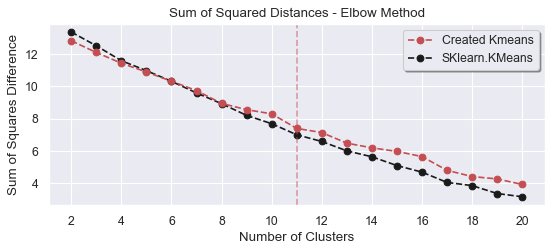

In [108]:
U, Sigma, VT = svd(a_standardized)
V = getValues(14,VT)
n = 21
n_clusters = np.array(range(2,n))
ss_values = []; ss_sklearn=[]
for i in n_clusters:
    kmeans = K_means(i)
    kmeans.main(V)
    sq=0
    ss = {}
    for i in kmeans.centroids:
        sq1=0
        centroid = kmeans.centroids[i]
        cluster_data = kmeans.clusters[i]
        for j in cluster_data:
            value = (np.array(j)-np.array(centroid))**2
            sq1+=sum(value)
            ss[i]=sq1
    ss_values.append(sum(ss.values()))
    kmeans_sklearn = KMeans(n_clusters=i, random_state=0).fit(V)
    ss_sklearn.append(kmeans_sklearn.inertia_)
    
fig,ax = plt.subplots(figsize=(8,3),dpi=80)
ax.plot(n_clusters,ss_values,'ro--',zorder=3,label = 'Created Kmeans')
ax.plot(n_clusters,ss_sklearn,'ko--',zorder=2,label = 'SKlearn.KMeans')
ax.set_xticks(n_clusters[::2])
ax.legend(loc='best',fancybox=True,shadow=True)
ax.set_ylabel('Sum of Squares Difference')
ax.set_xlabel('Number of Clusters')
ax.set_title('Sum of Squared Distances - Elbow Method')
ax.axvline(11,color='r',linestyle='--',alpha=0.5)

Min. intercluster: 0.3325
Max. intracluster: 0.8951
Dunn index: 0.2966


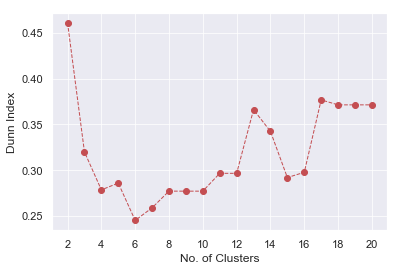

In [109]:
Dunn_index = {}
V = getValues(14,VT) # Only using first two PCs
for i in range(2,21):
    kmeans = K_means(i)
    kmeans.main(V)
    
    c,inter = intercluster_distance(kmeans.centroids)
    intra = intracluster_distance(kmeans.clusters)
    Dunn_index[i] = min(inter)/max(intra)

fig,ax = plt.subplots();
ax.plot(Dunn_index.keys(),Dunn_index.values(),'ro--',linewidth=1)
ax.set_xticks(Dunn_index.keys()[::2])
ax.set_xlabel('No. of Clusters')
ax.set_ylabel('Dunn Index')
ax.grid(alpha=0.75)
ax.axes.set_axisbelow(True)
print 'Min. intercluster: %.4f'%min(inter)
print 'Max. intracluster: %.4f'%max(intra)
print 'Dunn index: %.4f'%Dunn_index[11]

1
1
7
3
1
22
6
6
5
1
2
2


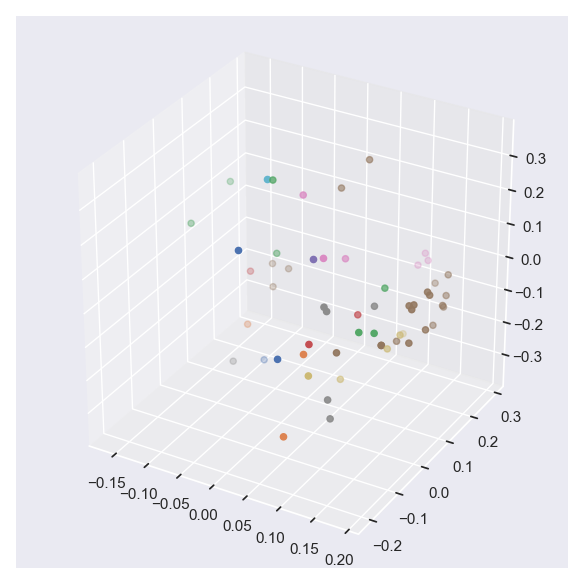

In [123]:
U, Sigma, VT = svd(a_standardized)
V = getValues(14,VT)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(111, projection='3d')

kmeans = K_means(12)
kmeans.main(V)

for classification in kmeans.clusters:
    x=[];y=[];z=[]
    for j in kmeans.clusters[classification]:
        x.append(j[0])
        y.append(j[1])
        z.append(j[2])
    print len(x)
    ax.scatter(x,y,z)
fig.tight_layout()
#plt.savefig('C:\Users\IAN\Research\COSC 528\Project 2\Figures/'+'KMeans_Cluster_'+str(i)+'.png',format='png',dpi=200)


### Expectation Maximization algorithm for Gaussian clusters

In [134]:
import math, random, copy
import numpy as np

def expectation_maximization(t, nbclusters=3, nbiter=3, normalize=False,\
        epsilon=0.001, monotony=False, datasetinit=True):
    """ 
    Each row of t is an observation, each column is a feature 
    'nbclusters' is the number of seeds and so of clusters
    'nbiter' is the number of iterations
    'epsilon' is the convergence bound/criterium

    Overview of the algorithm:
    -> Draw nbclusters sets of (μ, σ, P_{#cluster}) at random (Gaussian 
       Mixture) [P(Cluster=0) = P_0 = (1/n).∑_{obs} P(Cluster=0|obs)]
    -> Compute P(Cluster|obs) for each obs, this is:
    [E] P(Cluster=0|obs)^t = P(obs|Cluster=0)*P(Cluster=0)^t
    -> Recalculate the mixture parameters with the new estimate
    [M] * P(Cluster=0)^{t+1} = (1/n).∑_{obs} P(Cluster=0|obs)
        * μ^{t+1}_0 = ∑_{obs} obs.P(Cluster=0|obs) / P_0
        * σ^{t+1}_0 = ∑_{obs} P(Cluster=0|obs)(obs-μ^{t+1}_0)^2 / P_0
    -> Compute E_t=∑_{obs} log(P(obs)^t)
       Repeat Steps 2 and 3 until |E_t - E_{t-1}| < ε
    """
    def pnorm(x, m, s):
        """ 
        Compute the multivariate normal distribution with values vector x,
        mean vector m, sigma (variances/covariances) matrix s
        """
        xmt = np.matrix(x-m).transpose()
        for i in xrange(len(s)):
            if s[i,i] <= sys.float_info[3]: # min float
                s[i,i] = sys.float_info[3]
        sinv = np.linalg.inv(s)
        xm = np.matrix(x-m)
        return (2.0*math.pi)**(-len(x)/2.0)*(1.0/math.sqrt(np.linalg.det(s)))\
                *math.exp(-0.5*(xm*sinv*xmt))

    def draw_params():
            if datasetinit:
                tmpmu = np.array([1.0*t[random.uniform(0,nbobs),:]],np.float64)
            else:
                tmpmu = np.array([random.uniform(min_max[f][0], min_max[f][1])\
                        for f in xrange(nbfeatures)], np.float64)
            return {'mu': tmpmu,\
                    'sigma': np.matrix(np.diag(\
                    [(min_max[f][1]-min_max[f][0])/2.0\
                    for f in xrange(nbfeatures)])),\
                    'proba': 1.0/nbclusters}

    nbobs = t.shape[0]
    nbfeatures = t.shape[1]
    min_max = []
    # find xranges for each features
    for f in xrange(nbfeatures):
        min_max.append((t[:,f].min(), t[:,f].max()))
    
    ### Normalization
    if normalize:
        for f in xrange(nbfeatures):
            t[:,f] -= min_max[f][0]
            t[:,f] /= (min_max[f][1]-min_max[f][0])
    min_max = []
    for f in xrange(nbfeatures):
        min_max.append((t[:,f].min(), t[:,f].max()))
    ### /Normalization

    result = {}
    quality = 0.0 # sum of the means of the distances to centroids
    random.seed()
    Pclust = np.ndarray([nbobs,nbclusters], np.float64) # P(clust|obs)
    Px = np.ndarray([nbobs,nbclusters], np.float64) # P(obs|clust)
    # iterate nbiter times searching for the best "quality" clustering
    for iteration in xrange(nbiter):
        ##############################################
        # Step 1: draw nbclusters sets of parameters #
        ##############################################
        params = [draw_params() for c in xrange(nbclusters)]
        old_log_estimate = sys.maxint         # init, not true/real
        log_estimate = sys.maxint/2 + epsilon # init, not true/real
        estimation_round = 0
        # Iterate until convergence (EM is monotone) <=> < epsilon variation
        while (abs(log_estimate - old_log_estimate) > epsilon\
                and (not monotony or log_estimate < old_log_estimate)):
            restart = False
            old_log_estimate = log_estimate
            ########################################################
            # Step 2: compute P(Cluster|obs) for each observations #
            ########################################################
            for o in xrange(nbobs):
                for c in xrange(nbclusters):
                    # Px[o,c] = P(x|c)
                    Px[o,c] = pnorm(t[o,:],\
                            params[c]['mu'], params[c]['sigma'])
            #for o in xrange(nbobs):
            #    Px[o,:] /= math.fsum(Px[o,:])
            for o in xrange(nbobs):
                for c in xrange(nbclusters):
                    # Pclust[o,c] = P(c|x)
                    Pclust[o,c] = Px[o,c]*params[c]['proba']
            #    assert math.fsum(Px[o,:]) >= 0.99 and\
            #            math.fsum(Px[o,:]) <= 1.01
            for o in xrange(nbobs):
                tmpSum = 0.0
                for c in xrange(nbclusters):
                    tmpSum += params[c]['proba']*Px[o,c]
                Pclust[o,:] /= tmpSum
                #assert math.fsum(Pclust[:,c]) >= 0.99 and\
                #        math.fsum(Pclust[:,c]) <= 1.01
            ###########################################################
            # Step 3: update the parameters (sets {mu, sigma, proba}) #
            ###########################################################
            print "iter:", iteration, " estimation#:", estimation_round,\
                    " params:", params
            for c in xrange(nbclusters):
                tmpSum = math.fsum(Pclust[:,c])
                params[c]['proba'] = tmpSum/nbobs
                if params[c]['proba'] <= 1.0/nbobs:           # restart if all
                    restart = True                             # converges to
                    print "Restarting, p:",params[c]['proba'] # one cluster
                    break
                m = np.zeros(nbfeatures, np.float64)
                for o in xrange(nbobs):
                    m += t[o,:]*Pclust[o,c]
                params[c]['mu'] = m/tmpSum
                s = np.matrix(np.diag(np.zeros(nbfeatures, np.float64)))
                for o in xrange(nbobs):
                    s += Pclust[o,c]*(np.matrix(t[o,:]-params[c]['mu']).transpose()*\
                            np.matrix(t[o,:]-params[c]['mu']))
                    #print ">>>> ", t[o,:]-params[c]['mu']
                    #diag = Pclust[o,c]*((t[o,:]-params[c]['mu'])*\
                    #        (t[o,:]-params[c]['mu']).transpose())
                    #print ">>> ", diag
                    #for i in xrange(len(s)) :
                    #    s[i,i] += diag[i]
                params[c]['sigma'] = s/tmpSum
                print "------------------"
                print params[c]['sigma']

            ### Test bound conditions and restart consequently if needed
            if not restart:
                restart = True
                for c in xrange(1,nbclusters):
                    if not np.allclose(params[c]['mu'], params[c-1]['mu'])\
                    or not np.allclose(params[c]['sigma'], params[c-1]['sigma']):
                        restart = False
                        break
            if restart:                # restart if all converges to only
                old_log_estimate = sys.maxint          # init, not true/real
                log_estimate = sys.maxint/2 + epsilon # init, not true/real
                params = [draw_params() for c in xrange(nbclusters)]
                continue
            ### /Test bound conditions and restart

            ####################################
            # Step 4: compute the log estimate #
            ####################################
            log_estimate = math.fsum([math.log(math.fsum(\
                    [Px[o,c]*params[c]['proba'] for c in xrange(nbclusters)]))\
                    for o in xrange(nbobs)])
            print "(EM) old and new log estimate: ",\
                    old_log_estimate, log_estimate
            estimation_round += 1

        # Pick/save the best clustering as the final result
        quality = -log_estimate
        if not quality in result or quality > result['quality']:
            result['quality'] = quality
            result['params'] = copy.deepcopy(params)
            result['clusters'] = [[o for o in xrange(nbobs)\
                    if Px[o,c] == max(Px[o,:])]\
                    for c in xrange(nbclusters)]
    return result

sklearn.cluster.k_means_.KMeans